# problem 2: Predicting future Targeted Regions

In [126]:
import sklearn
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme (style="darkgrid")
print(sklearn.__version__)  # This will print the version of scikit-learn installed


1.6.1


C:\Users\sonny bell\AppData\Local\Temp\ipykernel_24964\1869878004.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['target_filled'] = df['target'].fillna(method='ffill').fillna(method='bfill')


Classes after grouping rare ones:
future_target
Odesa oblast                                170
Kherson oblast                              154
Mykolaiv oblast                             102
Other                                        90
Kharkiv oblast                               68
Dnipropetrovsk oblast                        45
Dnipropetrovsk oblast, Dnipro Raion          34
Dnipropetrovsk oblast, Kryvyi Rih Raion      26
Zaporizhzhia oblast                          24
Kyiv oblast                                  22
Donetsk oblast                               20
Sumy oblast                                  17
Poltava oblast                               16
Odesa oblast and Mykolaiv oblast             16
Kryvyi Rih                                   12
Dnipro                                       11
Mykolaiv oblast and Kherson oblast           10
Dnipropetrovsk oblast, Synelnykove Raion     10
Chernihiv oblast                              7
Khmelnytskyi oblast                     

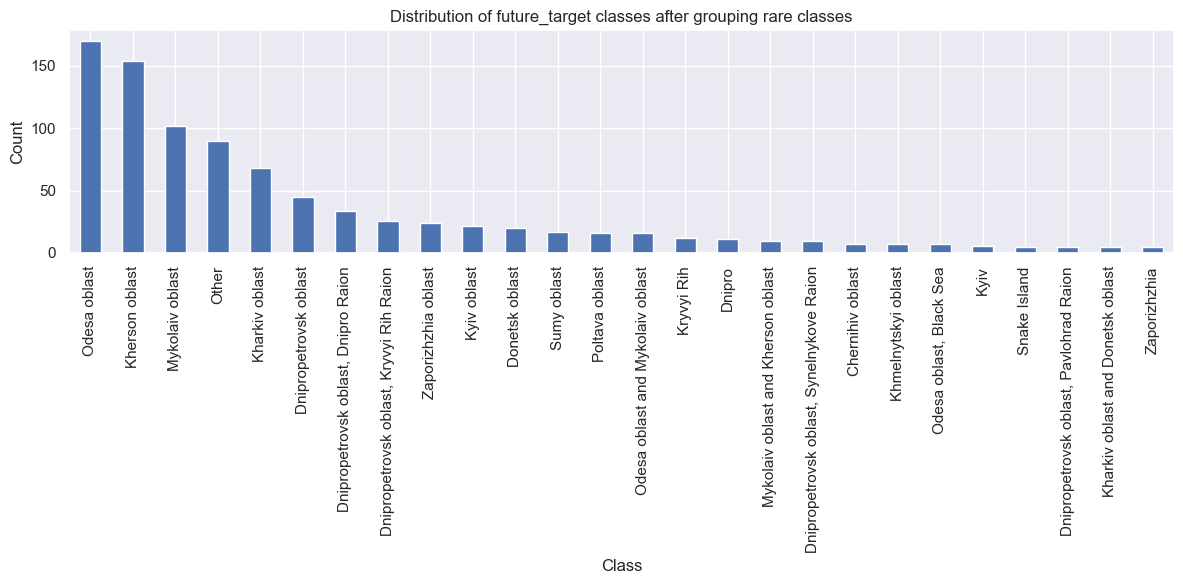

Model accuracy: 0.26


In [127]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("model2_dataset.csv")

# Convert time_start to datetime
df['time_start'] = pd.to_datetime(df['time_start'])

# Fill missing 'target' using forward/backward fill, ordered by time
df = df.sort_values(by='time_start')
df['target_filled'] = df['target'].fillna(method='ffill').fillna(method='bfill')

# Sort by target_filled and time for proper lag creation
df = df.sort_values(by=['target_filled', 'time_start'])

# Add lag features based on target_filled
df['launched_lag1'] = df.groupby('target_filled')['launched'].shift(1).fillna(0)
df['destroyed_lag1'] = df.groupby('target_filled')['destroyed'].shift(1).fillna(0)
df['launched_lag2'] = df.groupby('target_filled')['launched'].shift(2).fillna(0)
df['destroyed_lag2'] = df.groupby('target_filled')['destroyed'].shift(2).fillna(0)

# Extract time-based features
df['year'] = df['time_start'].dt.year
df['month'] = df['time_start'].dt.month
df['day'] = df['time_start'].dt.day
df['hour'] = df['time_start'].dt.hour

# Encode target_filled as numerical feature
df['target_filled_encoded'] = OrdinalEncoder().fit_transform(df[['target_filled']])

# Drop original datetime column
df = df.drop(columns=['time_start'])

# Define features
X = df[['year', 'month', 'day', 'hour', 'launched', 'destroyed',
        'launched_lag1', 'destroyed_lag1', 'launched_lag2', 'destroyed_lag2',
        'target_filled_encoded']]

# Define target variable
y = df['future_target']

# Drop rows with missing target
mask = y.notnull()
X = X[mask]
y = y[mask]

# Group rare classes into "Other"
min_count = 5
value_counts = y.value_counts()
rare_classes = value_counts[value_counts < min_count].index
y_grouped = y.copy()
y_grouped[y_grouped.isin(rare_classes)] = "Other"

print(f"Classes after grouping rare ones:\n{y_grouped.value_counts()}\n")

# Encode the grouped target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_grouped)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on missing future_target
X_missing = df.loc[df['future_target'].isnull(), X.columns]
if not X_missing.empty:
    y_missing_pred = rf.predict(X_missing)
    predicted_labels = le.inverse_transform(y_missing_pred)
    print("Predictions for missing future_target rows:")
    print(predicted_labels)
else:
    print("No missing future_target rows to predict.")

# Visualize class distribution
plt.figure(figsize=(12,6))
pd.Series(y_grouped).value_counts().plot(kind='bar')
plt.title("Distribution of future_target classes after grouping rare classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Evaluate accuracy
accuracy = rf.score(X_test, y_test)
print(f"Model accuracy: {accuracy:.2f}")


## Re training with XGBoost 

C:\Users\sonny bell\AppData\Local\Temp\ipykernel_24964\2756281104.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['target_filled'] = df['target'].fillna(method='ffill').fillna(method='bfill')
c:\Users\sonny bell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:20:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classes after grouping rare ones:
 future_target
Odesa oblast                                170
Kherson oblast                              154
Mykolaiv oblast                             102
Other                                        90
Kharkiv oblast                               68
Dnipropetrovsk oblast                        45
Dnipropetrovsk oblast, Dnipro Raion          34
Dnipropetrovsk oblast, Kryvyi Rih Raion      26
Zaporizhzhia oblast                          24
Kyiv oblast                                  22
Donetsk oblast                               20
Sumy oblast                                  17
Poltava oblast                               16
Odesa oblast and Mykolaiv oblast             16
Kryvyi Rih                                   12
Dnipro                                       11
Mykolaiv oblast and Kherson oblast           10
Dnipropetrovsk oblast, Synelnykove Raion     10
Chernihiv oblast                              7
Khmelnytskyi oblast                    

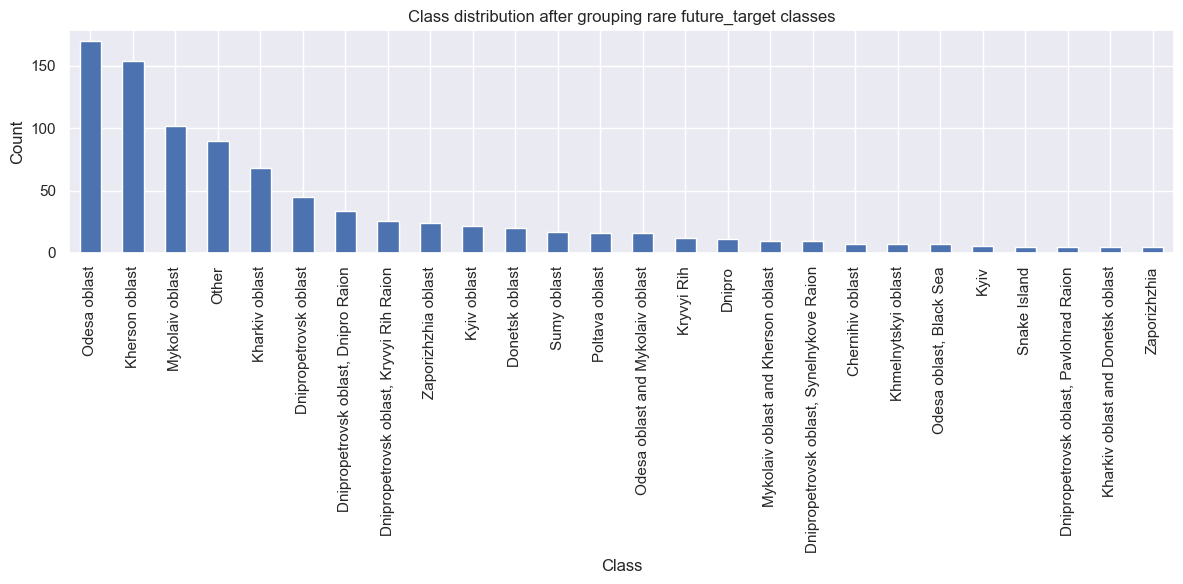

Model accuracy (Improved XGBoost): 0.27


In [131]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Load and sort
df = pd.read_csv("model2_dataset.csv")
df['time_start'] = pd.to_datetime(df['time_start'])
df = df.sort_values(by='time_start')

# Fill missing target
df['target_filled'] = df['target'].fillna(method='ffill').fillna(method='bfill')

# Group by location for temporal features
df = df.sort_values(by=['target_filled', 'time_start'])

# Lag features
df['launched_lag1'] = df.groupby('target_filled')['launched'].shift(1).fillna(0)
df['destroyed_lag1'] = df.groupby('target_filled')['destroyed'].shift(1).fillna(0)
df['launched_lag2'] = df.groupby('target_filled')['launched'].shift(2).fillna(0)
df['destroyed_lag2'] = df.groupby('target_filled')['destroyed'].shift(2).fillna(0)

# Rolling stats (3-step mean)
df['launched_roll3'] = df.groupby('target_filled')['launched'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
df['destroyed_roll3'] = df.groupby('target_filled')['destroyed'].rolling(3, min_periods=1).mean().reset_index(0, drop=True)

# Cumulative features
df['launched_cumsum'] = df.groupby('target_filled')['launched'].cumsum()
df['destroyed_cumsum'] = df.groupby('target_filled')['destroyed'].cumsum()

# Attack ratio
df['attack_ratio'] = (df['destroyed'] + 1) / (df['launched'] + 1)

# Binary attack indicator
df['had_attack'] = (df['launched'] > 0).astype(int)

# Date-based features
df['year'] = df['time_start'].dt.year
df['month'] = df['time_start'].dt.month
df['day'] = df['time_start'].dt.day
df['hour'] = df['time_start'].dt.hour
df['dayofweek'] = df['time_start'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# Ordinal encoding of location
df['target_filled_encoded'] = OrdinalEncoder().fit_transform(df[['target_filled']])

# Drop datetime
df = df.drop(columns=['time_start'])

# Select features
feature_cols = [
    'year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend',
    'launched', 'destroyed', 'attack_ratio', 'had_attack',
    'launched_lag1', 'destroyed_lag1', 'launched_lag2', 'destroyed_lag2',
    'launched_roll3', 'destroyed_roll3', 'launched_cumsum', 'destroyed_cumsum',
    'target_filled_encoded'
]

X = df[feature_cols]
y = df['future_target']

# Filter out null targets
mask = y.notnull()
X = X[mask]
y = y[mask]

# Group rare target labels
min_count = 5
value_counts = y.value_counts()
rare_classes = value_counts[value_counts < min_count].index
y_grouped = y.copy()
y_grouped[y_grouped.isin(rare_classes)] = "Other"

print("Classes after grouping rare ones:\n", y_grouped.value_counts(), "\n")

# Encode target
le = LabelEncoder()
y_encoded = le.fit_transform(y_grouped)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# Predict missing
X_missing = df.loc[df['future_target'].isnull(), feature_cols]
if not X_missing.empty:
    y_missing_pred = xgb.predict(X_missing)
    predicted_labels = le.inverse_transform(y_missing_pred)
    print("Predictions for missing future_target rows:\n", predicted_labels)
else:
    print("No missing future_target rows to predict.")

# Plot class distribution
plt.figure(figsize=(12, 6))
pd.Series(y_grouped).value_counts().plot(kind='bar')
plt.title("Class distribution after grouping rare future_target classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Evaluate
accuracy = xgb.score(X_test, y_test)
print(f"Model accuracy (Improved XGBoost): {accuracy:.2f}")


Tuning the XGBoost Pipeline with optuna

In [132]:
import optuna
from sklearn.metrics import accuracy_score

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "use_label_encoder": False,
        "eval_metric": "mlogloss",
        "random_state": 42,
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return acc

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)  # Tune for 10 minutes or 50 trials

# Best params
print("Best trial:")
print(f"  Value (accuracy): {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")

# Train final model with best parameters
best_params = study.best_trial.params
best_params.update({
    "use_label_encoder": False,
    "eval_metric": "mlogloss",
    "random_state": 42
})
xgb_best = XGBClassifier(**best_params)
xgb_best.fit(X_train, y_train)

# Predict missing
if not X_missing.empty:
    y_missing_pred = xgb_best.predict(X_missing)
    predicted_labels = le.inverse_transform(y_missing_pred)
    print("Predictions for missing future_target rows:\n", predicted_labels)

# Final evaluation
accuracy = xgb_best.score(X_test, y_test)
print(f"Final Tuned XGBoost Accuracy: {accuracy:.2f}")


c:\Users\sonny bell\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-16 21:22:54,208] A new study created in memory with name: no-name-ec5d1806-74b4-4df7-9fb2-7a359212ff64
c:\Users\sonny bell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:22:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-06-16 21:22:54,579] Trial 0 finished with value: 0.2849162011173184 and parameters: {'n_estimators': 166, 'max_depth': 5, 'learning_rate': 0.08311266476539167, 'subsample': 0.9006355921876443, 'colsample_bytree': 0.6401643640449393, 'gamma': 4.976752435800229, 'reg_alpha': 3.9598617247371912, 'reg_lamb

Best trial:
  Value (accuracy): 0.3128491620111732
  Params: {'n_estimators': 442, 'max_depth': 10, 'learning_rate': 0.0244056421494939, 'subsample': 0.6093710514440509, 'colsample_bytree': 0.6443097115377898, 'gamma': 0.005159553717024604, 'reg_alpha': 3.9298235584835983, 'reg_lambda': 0.12502224508081025}
Predictions for missing future_target rows:
 ['Odesa oblast' 'Other' 'Odesa oblast' 'Odesa oblast' 'Other'
 'Dnipropetrovsk oblast' 'Dnipropetrovsk oblast' 'Odesa oblast'
 'Donetsk oblast' 'Donetsk oblast' 'Donetsk oblast' 'Kherson oblast'
 'Dnipropetrovsk oblast' 'Odesa oblast' 'Odesa oblast' 'Odesa oblast'
 'Odesa oblast' 'Donetsk oblast' 'Kherson oblast' 'Kherson oblast' 'Other'
 'Kharkiv oblast' 'Dnipropetrovsk oblast' 'Dnipropetrovsk oblast'
 'Dnipropetrovsk oblast' 'Dnipropetrovsk oblast' 'Dnipropetrovsk oblast'
 'Dnipropetrovsk oblast' 'Dnipropetrovsk oblast' 'Dnipropetrovsk oblast'
 'Dnipropetrovsk oblast' 'Dnipropetrovsk oblast' 'Dnipropetrovsk oblast'
 'Dnipropetrovsk obla

## Trying the same pipeline in LGBM (Light Gradient Boosting Machine)

In [141]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("model2_dataset.csv")

# Convert time_start to datetime and sort for lag features
df['time_start'] = pd.to_datetime(df['time_start'])
df = df.sort_values(by=['target', 'time_start'])

# Fill missing 'target' with a placeholder for lag grouping
df['target_filled'] = df['target'].fillna('Unknown')

# Add lag features
df['launched_lag1'] = df.groupby('target_filled')['launched'].shift(1).fillna(0)
df['destroyed_lag1'] = df.groupby('target_filled')['destroyed'].shift(1).fillna(0)
df['launched_lag2'] = df.groupby('target_filled')['launched'].shift(2).fillna(0)
df['destroyed_lag2'] = df.groupby('target_filled')['destroyed'].shift(2).fillna(0)

# Add additional features
df['year'] = df['time_start'].dt.year
df['month'] = df['time_start'].dt.month
df['day'] = df['time_start'].dt.day
df['hour'] = df['time_start'].dt.hour
df['weekday'] = df['time_start'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['efficiency'] = df['destroyed'] / (df['launched'] + 1e-3)
df['efficiency'] = df['efficiency'].fillna(0).clip(0, 1)

# Drop the datetime column and target_filled (used only for grouping)
df = df.drop(columns=['time_start', 'target_filled'])

# Define features and target
features = ['year', 'month', 'day', 'hour', 'weekday', 'is_weekend',
            'launched', 'destroyed', 'launched_lag1', 'destroyed_lag1',
            'launched_lag2', 'destroyed_lag2', 'efficiency']

X = df[features]
y = df['future_target']

# Drop rows with missing target
mask = y.notnull()
X = X[mask]
y = y[mask]

# Group rare target classes into "Other"
min_count = 5
value_counts = y.value_counts()
rare_classes = value_counts[value_counts < min_count].index
y_grouped = y.copy()
y_grouped[y_grouped.isin(rare_classes)] = "Other"

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_grouped)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train LightGBM
lgbm = lgb.LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

# Evaluate
accuracy = lgbm.score(X_test, y_test)
accuracy


0.22905027932960895